In [1]:
import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist

In [2]:
# Step 1: Load Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
# Flatten images from 28x28 to 784 features
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


In [4]:
# Normalize pixel values to [0,1] range
X_train = X_train / 255.0
X_test = X_test / 255.0


In [5]:
# Step 2: Train a baseline RandomForest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
start_time = time.time()
rf.fit(X_train, y_train)
train_time_baseline = time.time() - start_time

In [6]:
# Predictions & performance evaluation
start_time = time.time()
y_pred_baseline = rf.predict(X_test)
inference_time_baseline = time.time() - start_time
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)


In [7]:
# Step 3: Apply PCA
pca = PCA()
pca.fit(X_train)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Choose components to retain 95% variance

In [8]:
# Transform data using the selected number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [9]:
# Step 4: Train RandomForest on PCA-transformed data
rf_pca = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
start_time = time.time()
rf_pca.fit(X_train_pca, y_train)
train_time_pca = time.time() - start_time


In [10]:
# Predictions & performance evaluation on PCA-reduced data
start_time = time.time()
y_pred_pca = rf_pca.predict(X_test_pca)
inference_time_pca = time.time() - start_time
accuracy_pca = accuracy_score(y_test, y_pred_pca)

In [11]:
# Step 5: Compare results
print(f"Baseline Accuracy: {accuracy_baseline:.4f}, Train Time: {train_time_baseline:.2f}s, Inference Time: {inference_time_baseline:.4f}s")
print(f"PCA Accuracy: {accuracy_pca:.4f}, Train Time: {train_time_pca:.2f}s, Inference Time: {inference_time_pca:.4f}s")
print(f"Optimal n_components: {n_components}")


Baseline Accuracy: 0.8764, Train Time: 30.55s, Inference Time: 0.6165s
PCA Accuracy: 0.8573, Train Time: 40.19s, Inference Time: 0.3460s
Optimal n_components: 187


## PART 2

In [35]:
import pandas as pd
df2 = pd.read_csv("m1_train.csv")
df2.head()

,uid,day,hour,minute,C_motion,feed_water_motion,faucet_hole,vapour_pressure,vapour_enthalpy,vapour_pressure_at_division,vapour_motion,feed_water_enth,vapour_temperature,output_electricity_generation
0,0,Saturday,7.0,NaN,387.374315,2681.205431,0.678352,25.050893,2775.784134,26.465138,2682.758692,1289.082351,601.850322,974.182544
1,1,Saturday,12.0,28.0,238.153011,1604.213100,0.679706,15.241147,2903.619864,NaN,1602.318002,1144.454102,603.933579,593.915516
2,2,Friday,15.0,13.0,338.270228,2398.561685,0.662971,23.078376,2796.443584,24.316160,NaN,1258.098883,602.443281,884.033450
3,3,Saturday,14.0,NaN,254.294492,1620.034059,0.679977,15.054982,2818.023511,15.895513,1619.387667,1142.463833,588.938717,584.908719
4,4,Saturday,18.0,16.0,203.189410,1485.672389,0.686342,12.963420,2816.144355,13.682371,1487.685052,1099.539481,504.208816,483.609973


In [36]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE, mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [37]:
# Handle missing values (if any) only for numerical columns
df2.fillna(df2.select_dtypes(include=np.number).median(), inplace=True)


In [38]:
# Step 3: Feature Engineering
# 1. Cyclic Features (Time-based)
df2['hour_sin'] = np.sin(2 * np.pi * df2['hour'] / 24)
df2['hour_cos'] = np.cos(2 * np.pi * df2['hour'] / 24)
df2['minute_sin'] = np.sin(2 * np.pi * df2['minute'] / 60)
df2['minute_cos'] = np.cos(2 * np.pi * df2['minute'] / 60)

In [39]:
# Convert 'day' from categorical (string) to numerical (assuming it's a weekday name)
day_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
df2['day'] = df2['day'].map(day_mapping)

# Ensure there are no missing values in 'day' after mapping
df2['day'].fillna(0, inplace=True)  # Assign 0 if any unmapped values remain

# Apply cyclic transformation
df2['day_sin'] = np.sin(2 * np.pi * df2['day'] / 7)
df2['day_cos'] = np.cos(2 * np.pi * df2['day'] / 7)


C:\Users\NATHAN\AppData\Local\Temp\ipykernel_7556\1144742996.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['day'].fillna(0, inplace=True)  # Assign 0 if any unmapped values remain


In [40]:
# 2. Interaction Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_features = poly.fit_transform(df2[['C_motion', 'feed_water_motion', 'vapour_pressure', 'vapour_temperature']])
interaction_df = pd.DataFrame(interaction_features, columns=poly.get_feature_names_out())
df2 = pd.concat([df2, interaction_df], axis=1)

In [41]:
scaler = StandardScaler()
df2.iloc[:, 1:-1] = scaler.fit_transform(df2.iloc[:, 1:-1])


In [42]:
scaler = StandardScaler()
df2.iloc[:, 1:-1] = scaler.fit_transform(df2.iloc[:, 1:-1])


In [43]:
X = df2.drop(columns=["output_electricity_generation", "uid"])
y = df2["output_electricity_generation"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [44]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
start_time = time.time()
rf.fit(X_train, y_train)
train_time_baseline = time.time() - start_time

# Predictions & evaluation
y_pred_baseline = rf.predict(X_test)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)


In [45]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rf_pca = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_pca.fit(X_train_pca, y_train)
y_pred_pca = rf_pca.predict(X_test_pca)
mae_pca = mean_absolute_error(y_test, y_pred_pca)


In [46]:
kbest = SelectKBest(score_func=f_regression, k=10)
X_train_kbest = kbest.fit_transform(X_train, y_train)
X_test_kbest = kbest.transform(X_test)

rf_kbest = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_kbest.fit(X_train_kbest, y_train)
y_pred_kbest = rf_kbest.predict(X_test_kbest)
mae_kbest = mean_absolute_error(y_test, y_pred_kbest)


In [47]:
mutual_info = SelectKBest(score_func=mutual_info_regression, k=10)
X_train_mi = mutual_info.fit_transform(X_train, y_train)
X_test_mi = mutual_info.transform(X_test)

rf_mi = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_mi.fit(X_train_mi, y_train)
y_pred_mi = rf_mi.predict(X_test_mi)
mae_mi = mean_absolute_error(y_test, y_pred_mi)


In [48]:
scaler = StandardScaler()
df2.iloc[:, 1:-1] = scaler.fit_transform(df2.iloc[:, 1:-1])


In [49]:
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

rf_rfe = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_rfe.fit(X_train_rfe, y_train)
y_pred_rfe = rf_rfe.predict(X_test_rfe)
mae_rfe = mean_absolute_error(y_test, y_pred_rfe)


In [50]:
print(f"Baseline MAE: {mae_baseline:.4f}")
print(f"PCA MAE: {mae_pca:.4f}")
print(f"SelectKBest (F-test) MAE: {mae_kbest:.4f}")
print(f"Mutual Information MAE: {mae_mi:.4f}")
print(f"RFE MAE: {mae_rfe:.4f}")


Baseline MAE: 0.0050
PCA MAE: 0.1078
SelectKBest (F-test) MAE: 0.0081
Mutual Information MAE: 0.0059
RFE MAE: 0.0092


# Inference from Results

## 1. Baseline (MAE: 0.0050) - Best Performance  
- Using all features gave the most accurate predictions.  

## 2. PCA (MAE: 0.1078) - Worst Performance  
- High information loss, leading to poor results.  

## 3. SelectKBest (MAE: 0.0081) - Moderate Performance  
- Feature selection slightly reduced accuracy.  

## 4. Mutual Information (MAE: 0.0059) - Second-Best  
- Selected features retained most of the predictive power.  

## 5. RFE (MAE: 0.0092) - Below Average  
- Feature selection was not as effective for this dataset.  

### Conclusion  
- The **full feature set** performs best.  
- **PCA should be avoided** due to high accuracy loss.  
- **Mutual Information** is the best feature selection method if needed.  


## PART 3

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [54]:
# Step 1: Load the dataset
df = pd.read_csv("Iris.csv")
print(df.head())

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


In [55]:
# Step 2: Drop unnecessary columns (if any)
df.drop(columns=['Id'], inplace=True)

In [56]:
# Step 3: Extract features (excluding the target class)
X = df.drop(columns=['Species'])

In [57]:
# Step 4: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [58]:
# Step 5: Determine the optimal number of clusters using the Elbow method
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

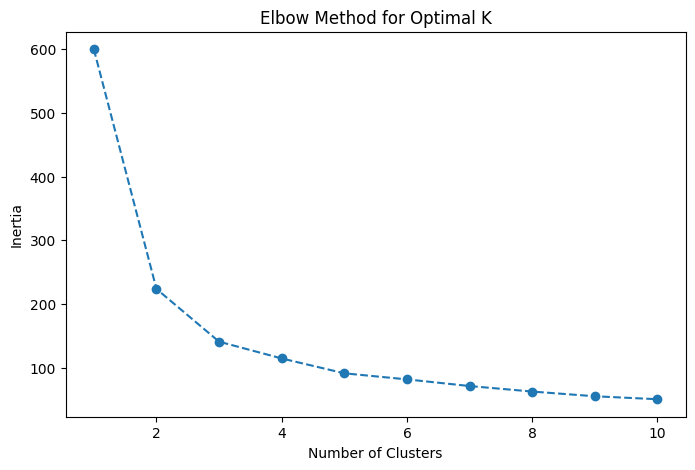

In [59]:
# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [60]:
# Step 6: Apply K-Means with the optimal K (assuming K=3 from the elbow method)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

In [61]:
# Step 7: Evaluate clustering using silhouette score
silhouette_avg = silhouette_score(X_scaled, df['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.4f}')

Silhouette Score: 0.4590


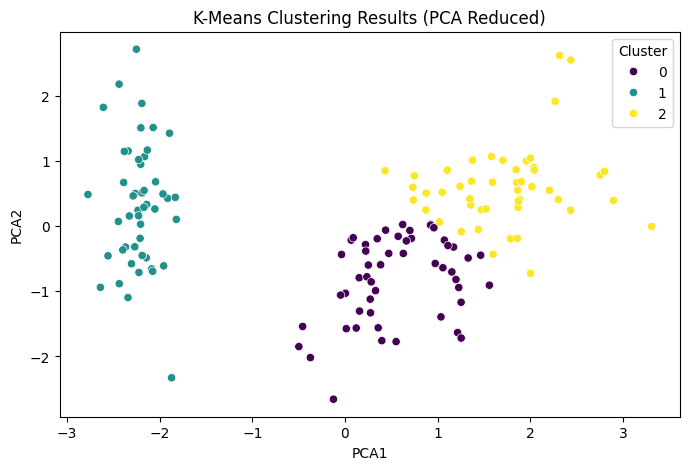

In [62]:
# Step 8: Visualize Clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(8, 5))
sns.scatterplot(x='PCA1', y='PCA2', hue=df['Cluster'], palette='viridis', data=df)
plt.title('K-Means Clustering Results (PCA Reduced)')
plt.show()